In [ ]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats 
import synergy_redundancy

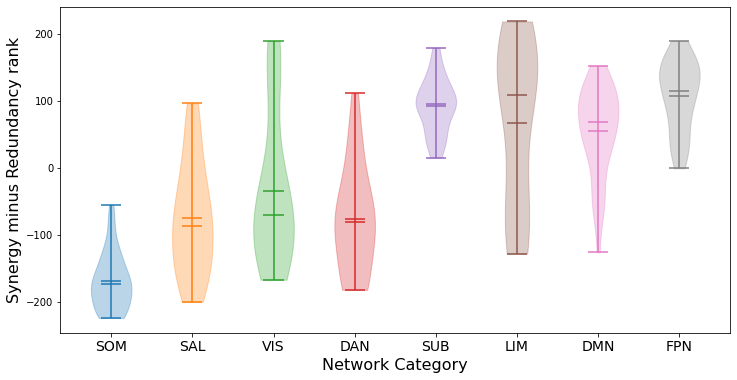

In [5]:
#Synergy minus redundancy for each canonical plot 
network_ranks = synergy_redundancy.network_analysis(rank_path='/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/resting_state_synergy_minus_redundancy_rank.csv',data_filepath = '/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/extended_schaefer_200 (1).csv' )
network_ranks_movie = synergy_redundancy.network_analysis(rank_path='/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/synergy_minus_redundancy_rank.csv',data_filepath = '/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/extended_schaefer_200 (1).csv' )

synergy_redundancy.networks_plot(network_ranks = network_ranks)


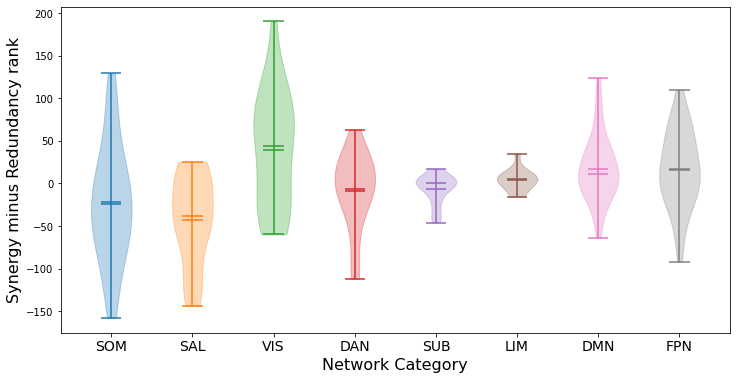

In [6]:
synergy_redundancy.networks_plot(network_ranks = network_ranks_movie)

In [42]:
def remove_outliers_iqr(data):
    '''
    Removed ourliers from the data
    '''
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if x >= lower_bound and x <= upper_bound]

In [44]:

def t_test():
    '''
    Performs 2 sample t test between the mean of each network
    '''
    for network in network_ranks.keys():
        x = network_ranks[network]
        y = network_ranks_movie[network] 
        x= remove_outliers_iqr(x)
        y = remove_outliers_iqr(y)

        N1 = len(network_ranks[network])
        N2 = len(network_ranks_movie[network])

        # Degrees of freedom  
        dof = min(N1,N2) - 1
        #computing the two-sample t-test
        t_stat, p_val = stats.ttest_ind(x,y)
        print(f"t-statistic for {network}= " + str(t_stat))  
        print("p-value = " + str(p_val))
t_test()

t-statistic for SOM= -10.479439476663474
p-value = 1.113690687574017e-15
t-statistic for SAL= -1.6166616792426247
p-value = 0.11224405306897434
t-statistic for VIS= -3.8906022987287012
p-value = 0.00033463274499991757
t-statistic for DAN= -4.889174653399399
p-value = 1.775686281284863e-05
t-statistic for SUB= 11.952964949776092
p-value = 2.1239630920106322e-17
t-statistic for LIM= 1.864999626196693
p-value = 0.07396162334298229
t-statistic for DMN= 4.385481001871086
p-value = 3.45016164536106e-05
t-statistic for FPN= 7.871842503436558
p-value = 2.6594097612680345e-11


In [82]:
def low_synergy_brain_regions():
    """
    Identifying brain regions that consistently exhibit low synergy with all other regions
    """
    #Examining the brain region which has the lowest synergy with all other regions

    extended_schaefer_200_data = pd.read_csv('/rds/general/user/ab5621/home/Masters-Dissertation/extended_schaefer_200 (1).csv')
    print(extended_schaefer_200_data.head())

    synergy_data = pd.read_csv('/rds/general/user/ab5621/home/Masters-Dissertation/Synergy_Redundancy_data/final_synergy_matrix.csv')
    synergy_data = np.array(synergy_data)
    synergy_data = synergy_data[:200, :200] #getting only the data from the brain areas in the Schaefer atlas

    #Seeing which brain regions have consistently low synergy with all other regions
    for brain_region_one in range(len(synergy_data)):
        count = 0
        for brain_region_two in range(len(synergy_data)):
            if synergy_data[brain_region_one][brain_region_two] < 0.08:
                count+=1
        if count == len(synergy_data):
            print(brain_region_one)

low_synergy_brain_regions()

51
161


In [83]:
extended_schaefer_200_data = pd.read_csv('/rds/general/user/ab5621/home/Masters-Dissertation/extended_schaefer_200 (1).csv')

print(extended_schaefer_200_data.iloc[51])
print(extended_schaefer_200_data.iloc[161])
#LimbicA and LimbicB networks exhibit lowest synergy with all other regions during movie watching

region          OFC 2
label              52
hemisphere          L
x                 -10
y                  35
z                 -21
network       LimbicB
Name: 51, dtype: object
region        TempPole 2
label                162
hemisphere             R
x                     47
y                    -12
z                    -35
network          LimbicA
Name: 161, dtype: object


GMM all info cluster analysis

In [8]:
def cluster_analysis(measure_labels):
    """
    Perform cluster-wise analysis by calculating the mean of each cluster's data

    Parameters
    ----------
    measure_labels : dict
        dict with keys that are cluster labels, and values are arrays containing data for each cluster

    Returns
    -------
    cluster_list : list
        list containing the mean values for each cluster
    """
    cluster_list = []
    for cluster in measure_labels.files:
        if measure_labels[cluster].size != 0:
            red_per_label = np.mean(measure_labels[cluster], axis = 1)
            cluster_list.append(red_per_label)
        else:
            cluster_list.append(measure_labels[cluster])
    return cluster_list

In [5]:

def info_measure_per_cluster(data):
    """
    Compute the average information measure for each cluster 

    Parameters
    ----------
    data : np.ndarray
        array where each element corresponds to the data of a specific cluster (synergy, red, uni)

    Returns
    -------
    data_dict : dict
        dictionary where keys are clusters(0 to 18) and values are the average information measure for each cluster
    """
    data_dict = dict()
    for i in range(19):
        avg_cluster = np.mean(data[i], axis = 1)
        data_dict[i] = avg_cluster
    return data_dict

In [11]:
with open('/rds/general/user/ab5621/home/Masters-Dissertation/Results/New_GMM/red_clusters.pkl', 'rb') as file:
    red_clusters = pickle.load(file)

In [5]:
with open('/rds/general/user/ab5621/home/Masters-Dissertation/Results/New_GMM/syn_clusters.pkl', 'rb') as file:
    syn_clusters = pickle.load(file)

In [16]:
with open('/rds/general/user/ab5621/home/Masters-Dissertation/Results/New_GMM/uni_clusters.pkl', 'rb') as file:
    uni_clusters = pickle.load(file)

In [8]:
def calculate_percentiles(data):
    """
    computes the 5th and 95th percentiles of data

    Parameters
    ----------
    data : np array

    Returns
    -------
    percentile_5th : float
        5th percentile of the data
    percentile_95th : float
        95th percentile of the data
    """
    combined_data = np.concatenate(data)

    # Calculate the 5th percentile
    percentile_5th = np.percentile(data, 5)

    # Calculate the 95th percentile
    percentile_95th = np.percentile(data, 95)

    return percentile_5th, percentile_95th

In [20]:
#5th and 95th percentile of the synergy data over all clusters
syn_list = []
for syn in syn_clusters.values():
    syn_list.append(syn)
calculate_percentiles(data = syn_list )

(-1.5911872787859178, 1.0202659145740989)

In [13]:
#5th and 95th percentile of the redundancy data over all clusters
red_list = []
for red in red_clusters.values():
    red_list.append(red)
calculate_percentiles(data = red_list )

(-0.06291812402871484, 0.1911412831590954)

In [14]:
#5th and 95th percentile of the unique data over all clusters
uni_list = []
for uni in uni_clusters.values():
    uni_list.append(uni)
calculate_percentiles(data = uni_list )

(-0.6088153761050008, 0.4465121889762732)